# High-Frequency Grid Trading

In this example, we will show you the entire process of backtesting, from data conversion using Tardis's historical data to backtesting with hftbacktest in Rust. To run this example, Python 3.10 and the latest versions of hftbacktest in Python and `gridtrading_backtest_args` in the examples of hftbacktest in Rust are required.

Firstly, you need to select which pairs you will backtest. `1_ticker.py` fetches ticker information from Binance Futures. You can set the number of pairs in the script. The `tickers.json` file used in this example is included.

`python 1_ticker.py`

Secondly, you need to download the data. L2 market depth and trade feed data are large, so they couldn't be included with the example. For historical data, this example uses Tardis's data. You can collect the data yourself using [this repo's program](https://github.com/nkaz001/collect-binancefutures) and convert it. Please see [Data Preparation](https://hftbacktest.readthedocs.io/en/latest/tutorials/Data%20Preparation.html) for details.

To run `2_download_tardis.py`, you need to set *TARDIS_KEY* and can specify the date range and path in the script.

`TARDIS_KEY=your_key python 2_download.py`

After downloading all necessary data, you need to convert the Tardis data into npz files that hftbacktest can consume. You can set the file paths and the number of processors for multiprocessing. Conversion requires a lot of memory, so monitor your memory usage, set the appropriate number of processors, and possibly adjust the buffer size.

`python 3_convert.py`

To achieve results close to actual trading, it's crucial to know your own order entry latency and response latency. If you don't have historical order latency data, as a second option, you can generate artificial order latency from the feed latency. Please see the script configuration.
Also, please refer to [Order Latency](https://hftbacktest.readthedocs.io/en/latest/tutorials/Order%20Latency%20Data.html) and [Latency Models](https://hftbacktest.readthedocs.io/en/latest/latency_models.html) for further information.

`python 4_latency.py`

Now, all data required for backtesting is prepared. You can set the path and parameters for the backtest. This will run the pre-compiled `gridtrading_backtest_args` written in Rust, which is also provided with the example. For more detailed information, please see the Python version example of [High-Frequency Grid Trading](https://hftbacktest.readthedocs.io/en/latest/tutorials/High-Frequency%20Grid%20Trading.html).

`python 5_backtest.py`

<div class="alert alert-info">
    <b>Note:</b> This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-01-03-f5d3200b65104308b8349cee59a2296e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
</div>

/tmp/ipykernel_229326/4052962145.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(i, figsize=(12, 6))


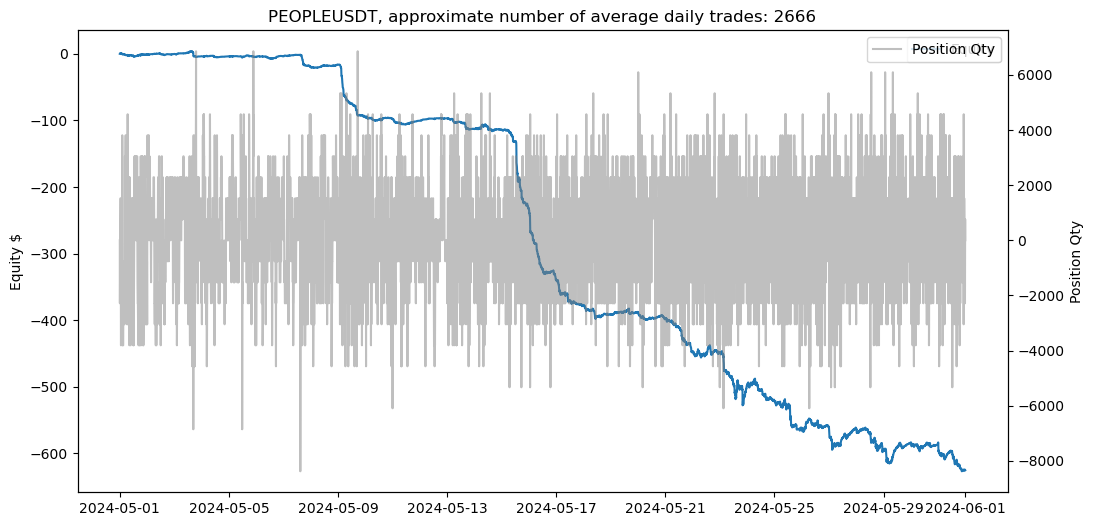

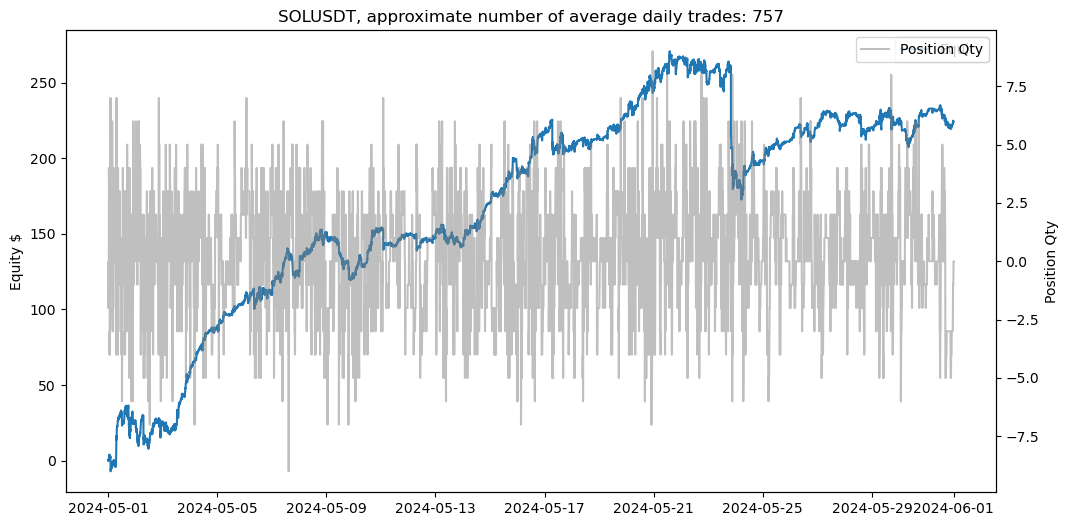

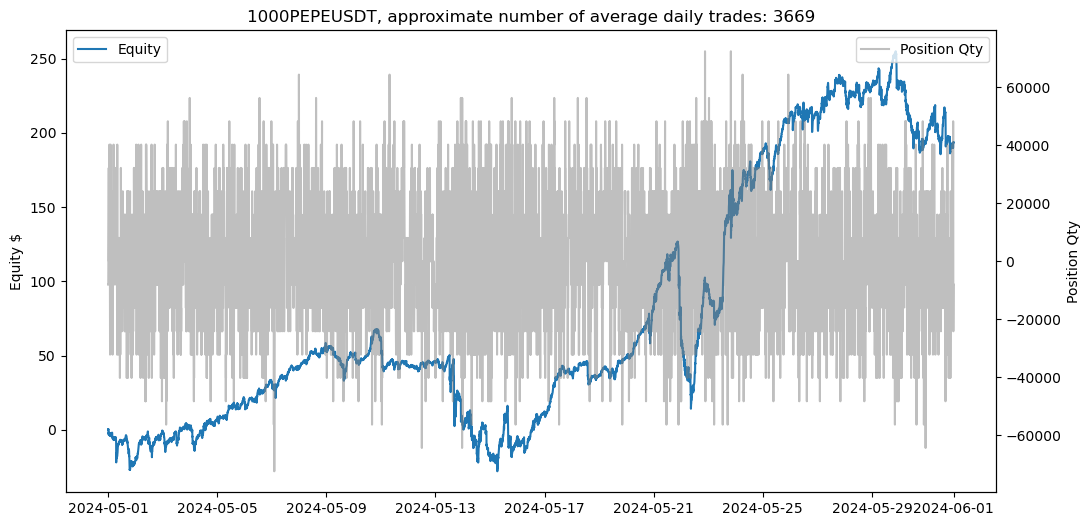

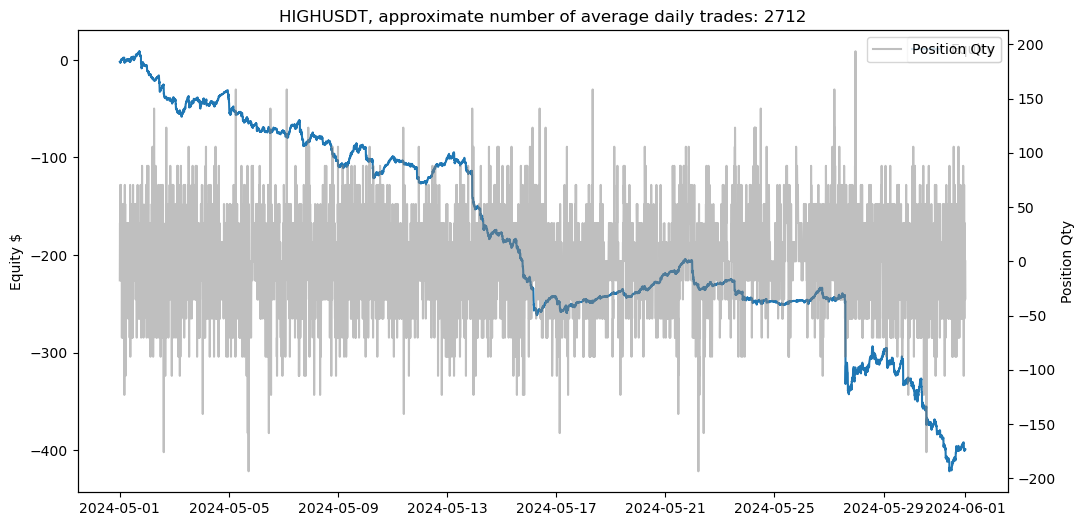

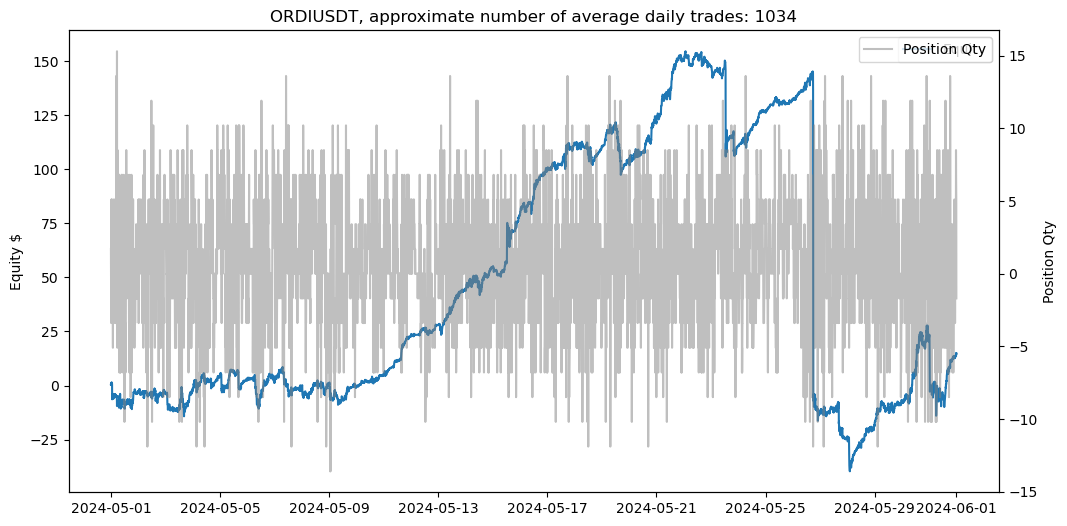

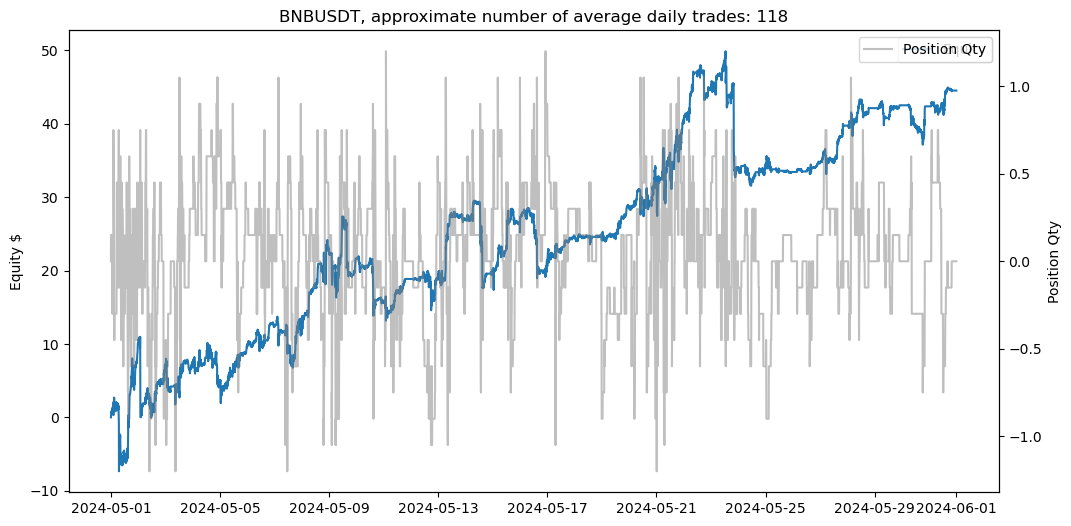

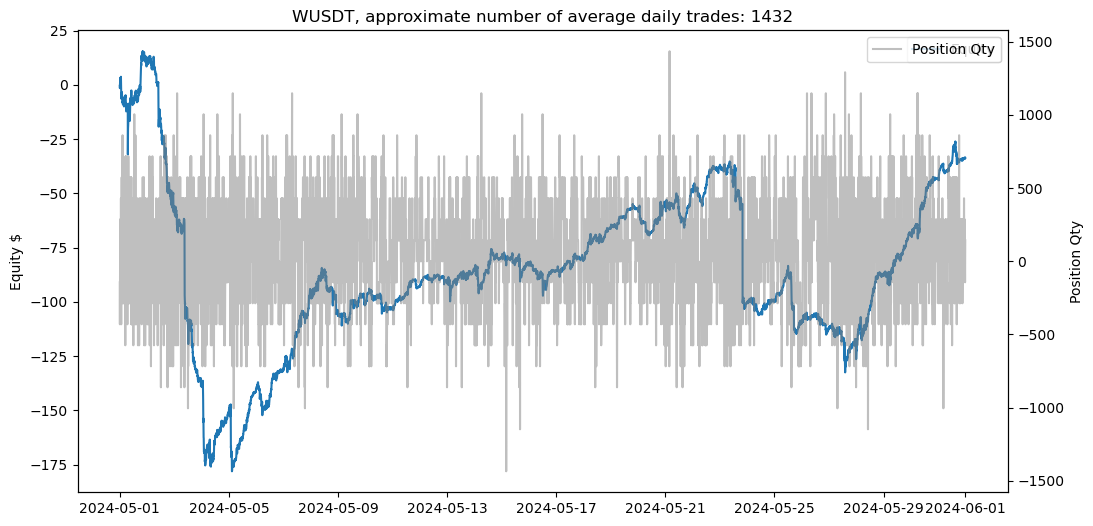

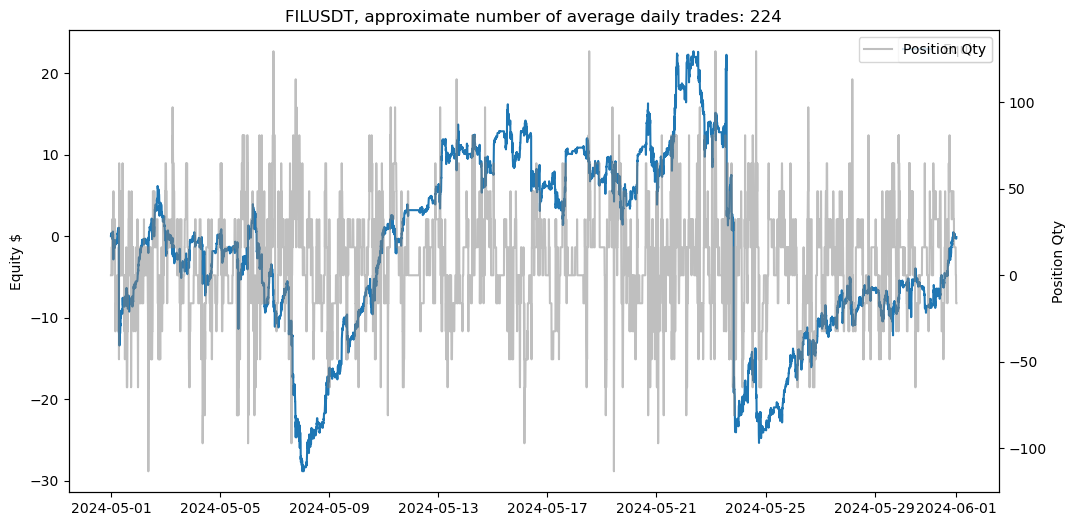

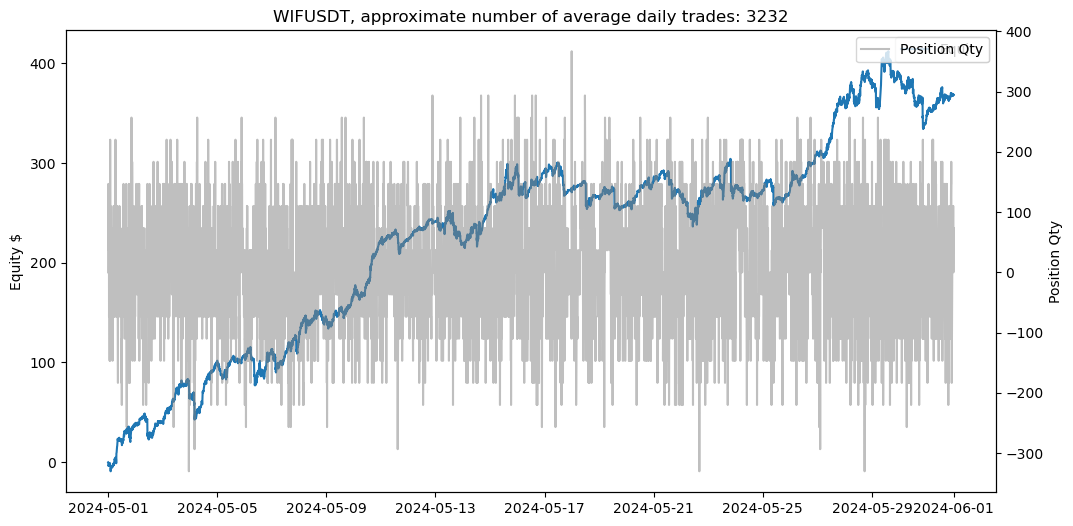

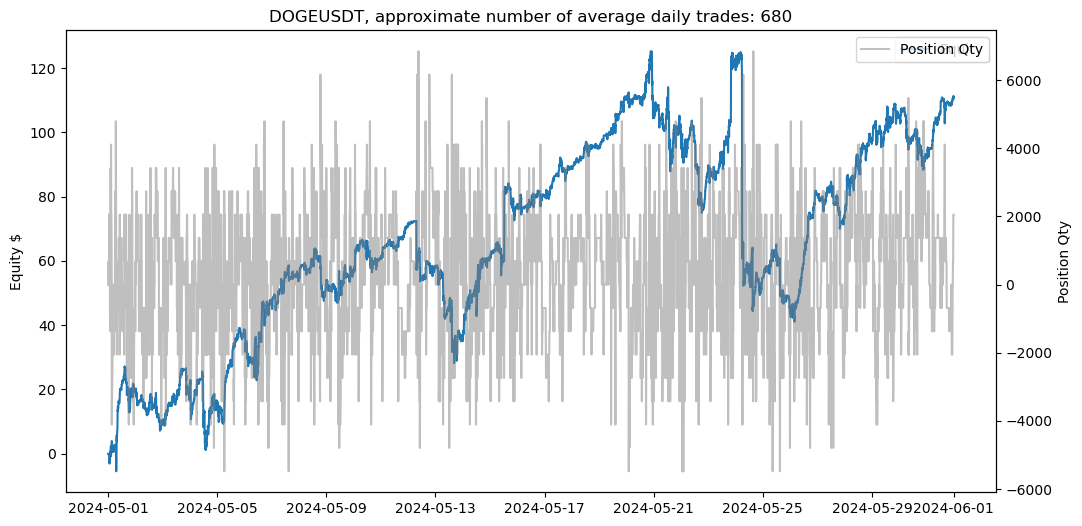

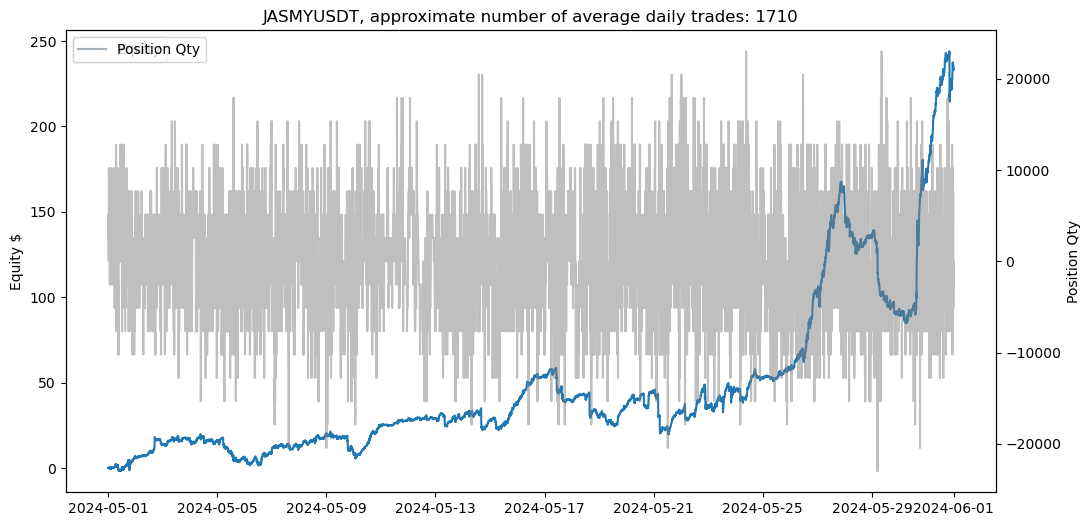

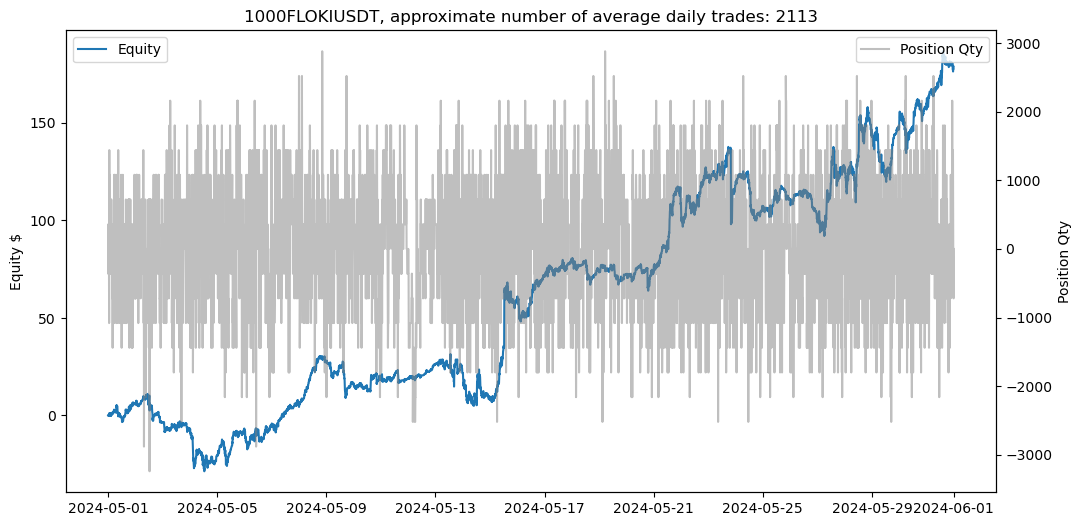

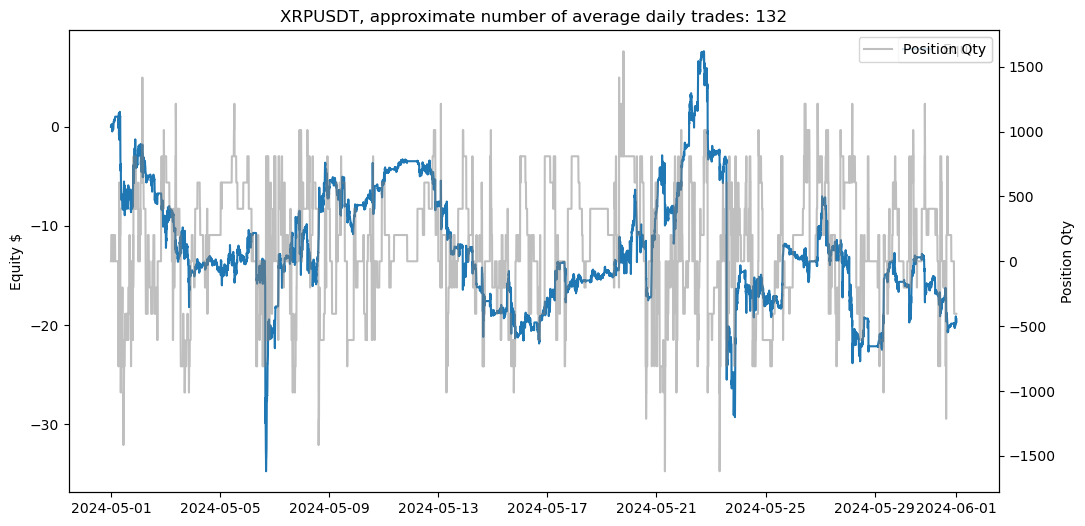

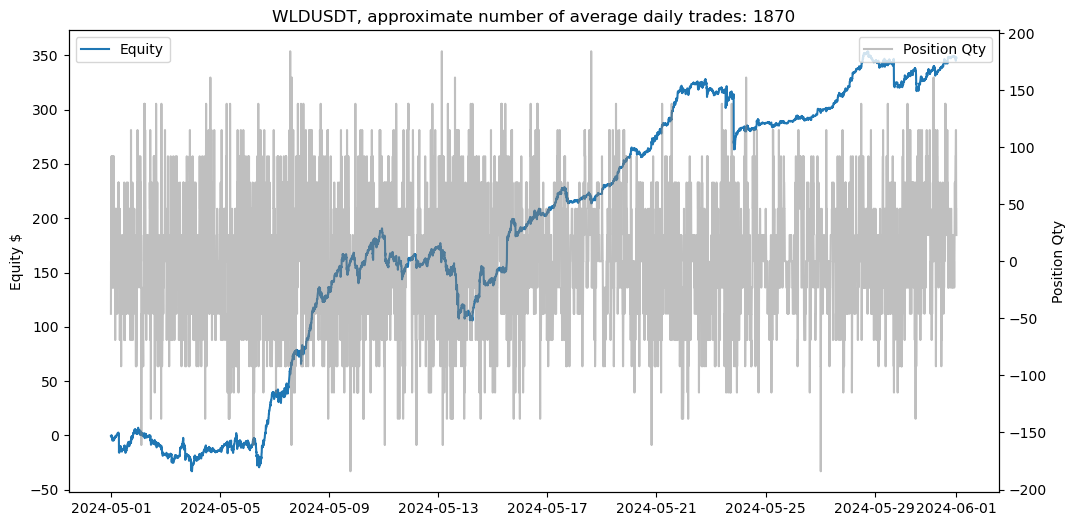

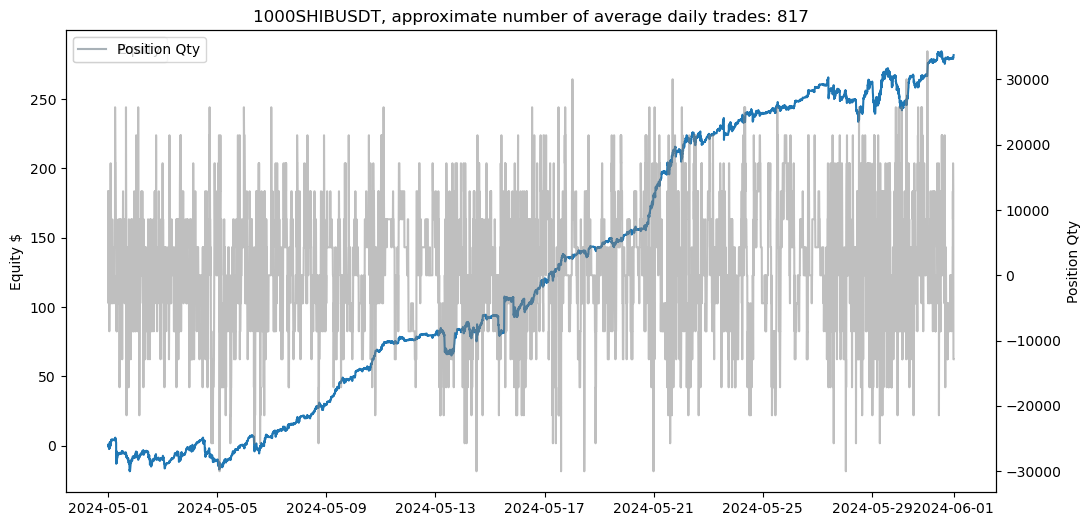

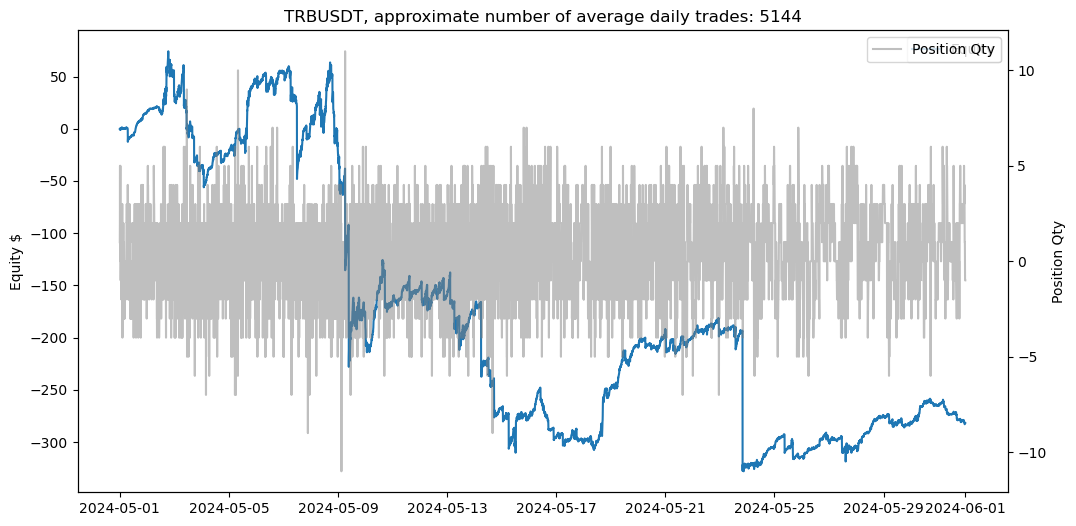

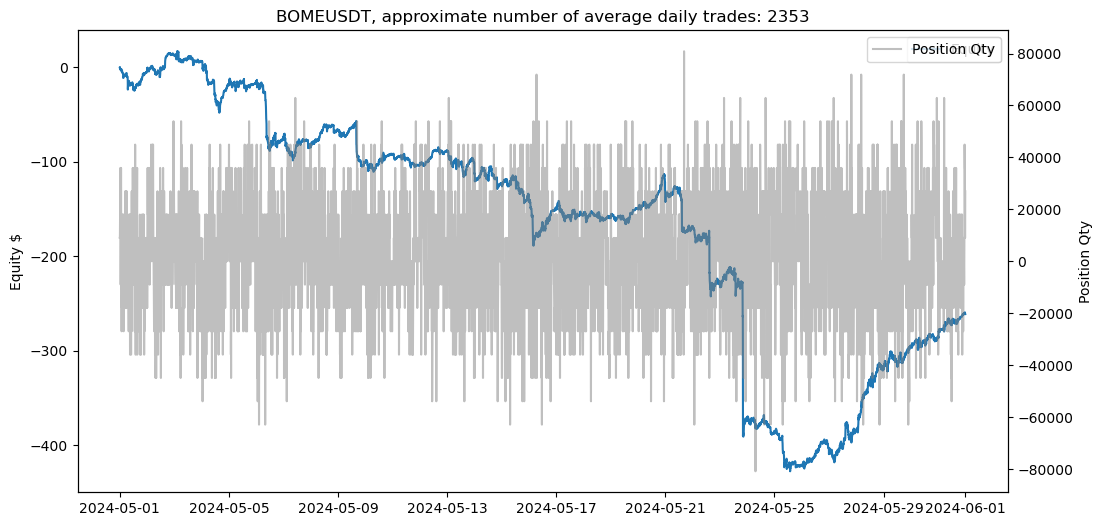

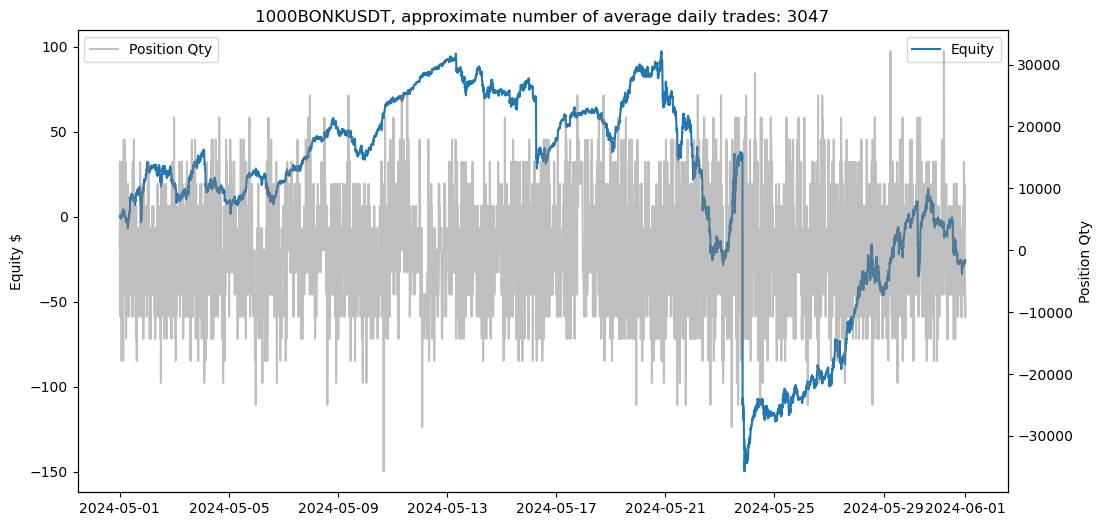

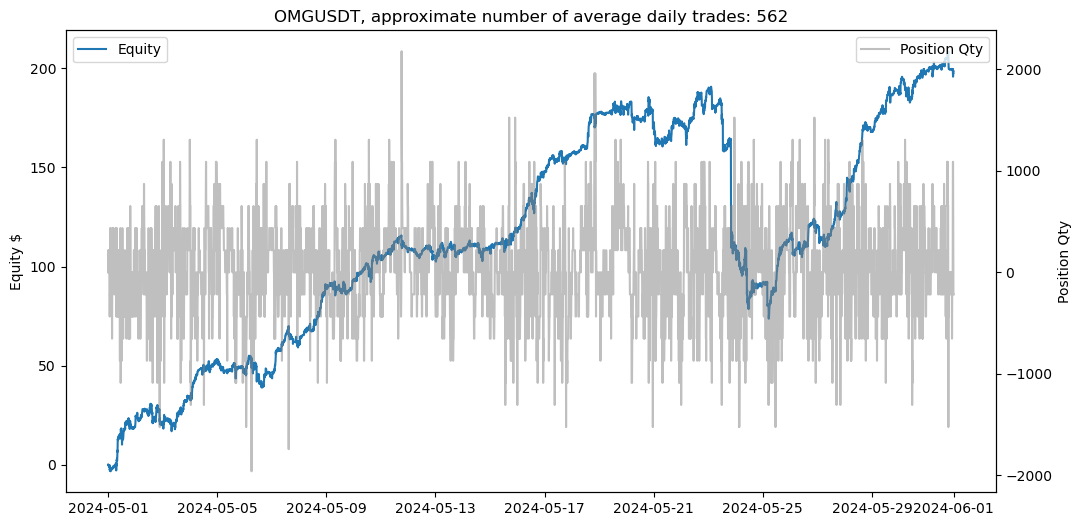

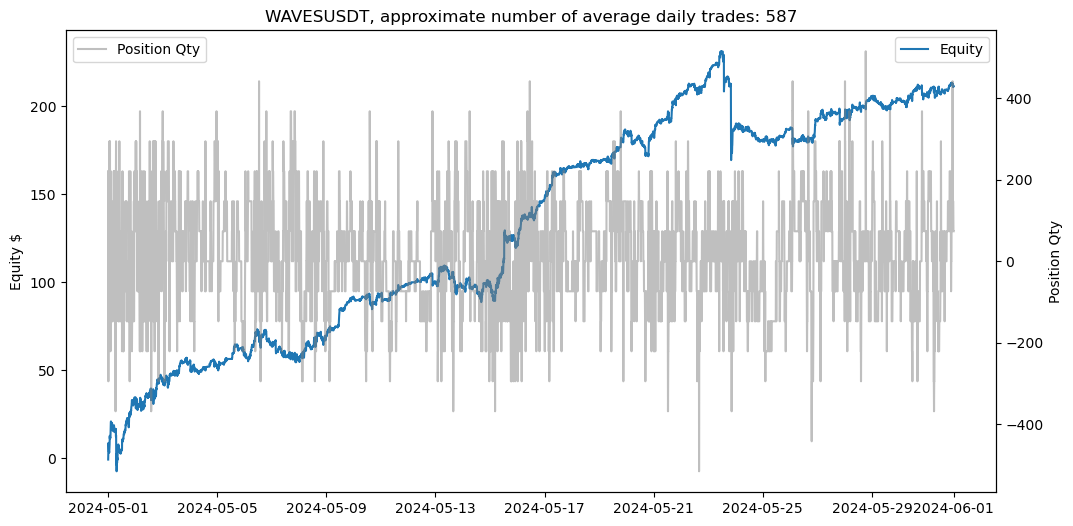

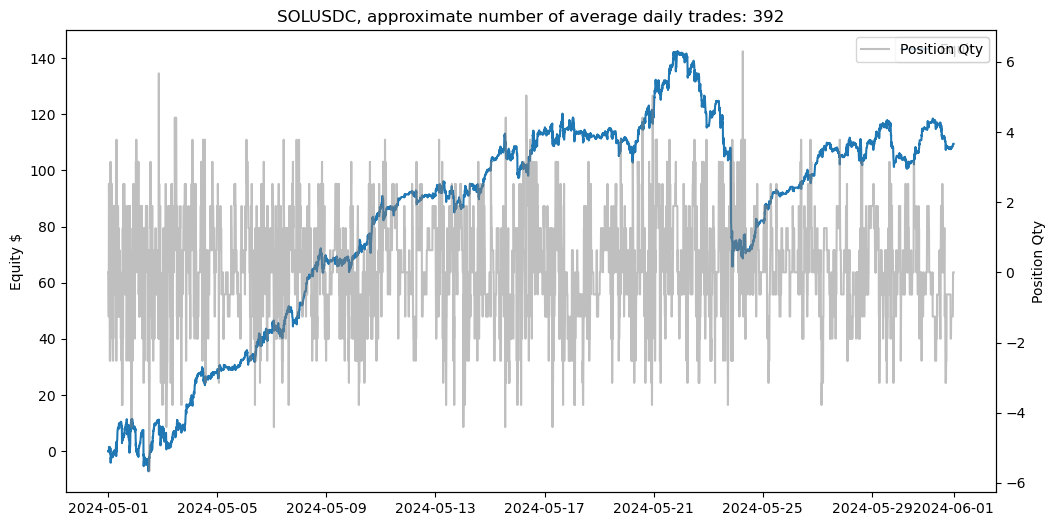

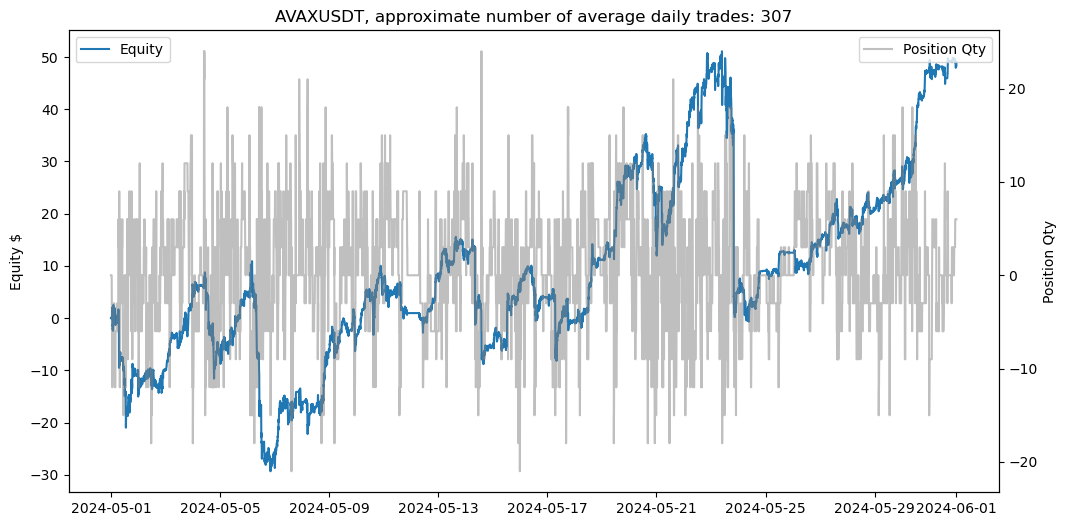

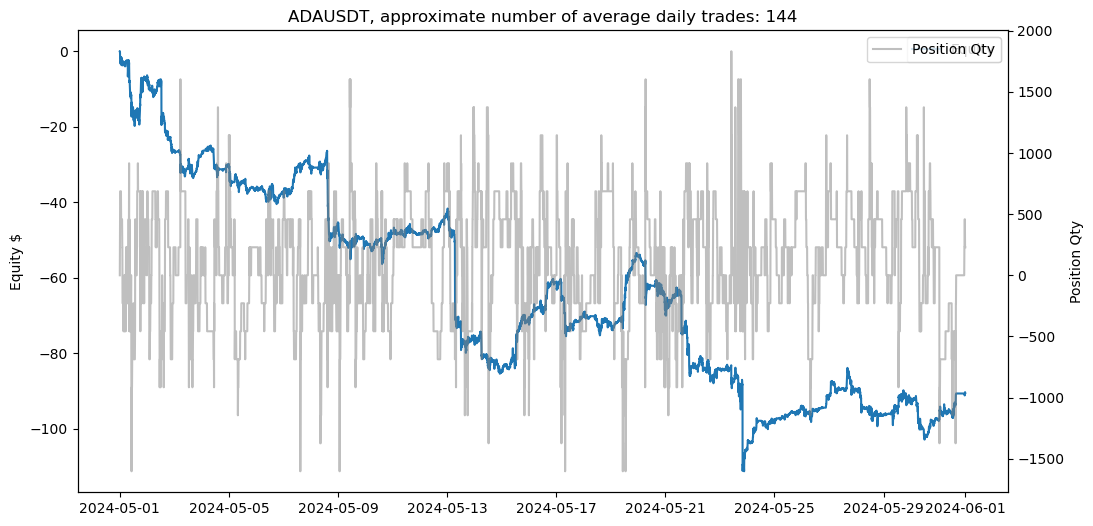

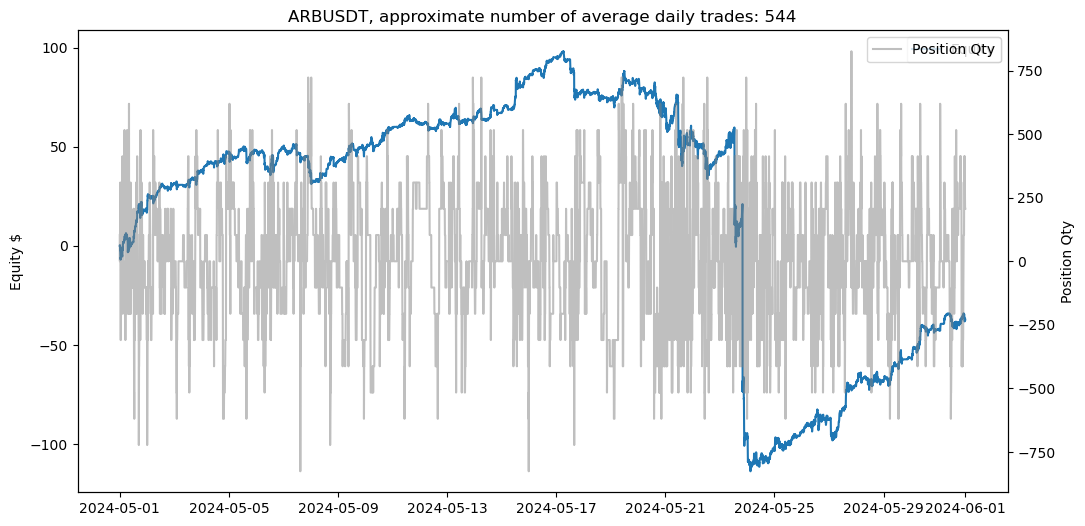

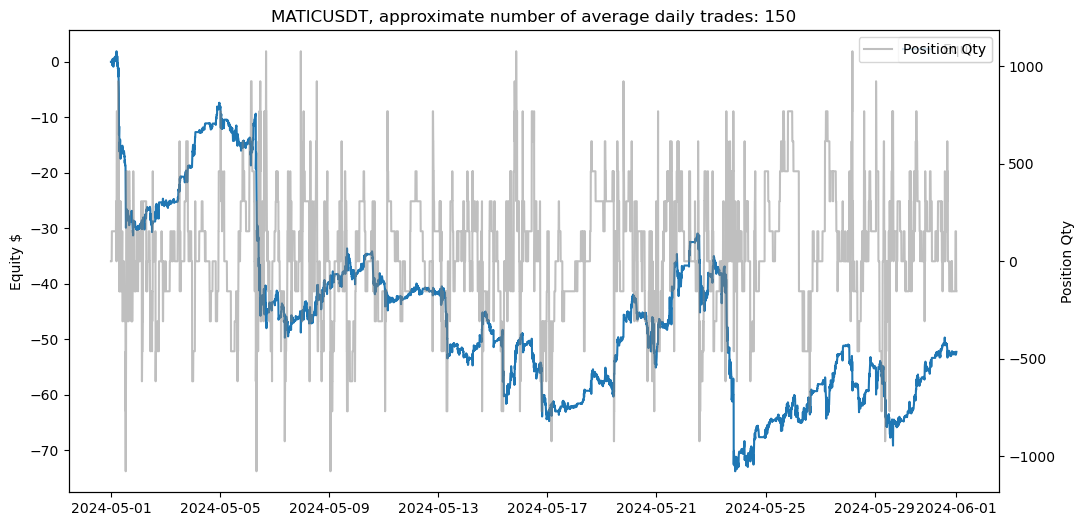

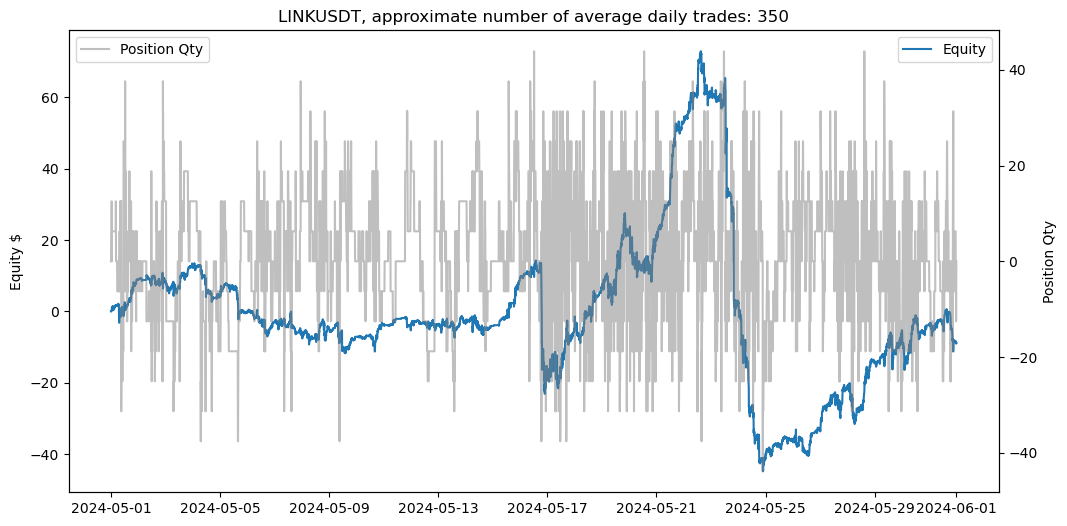

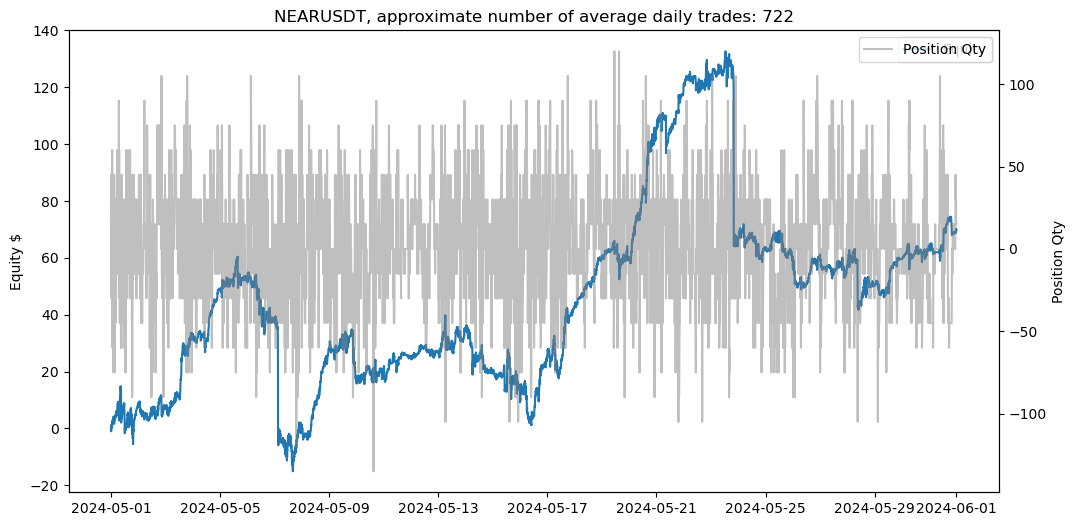

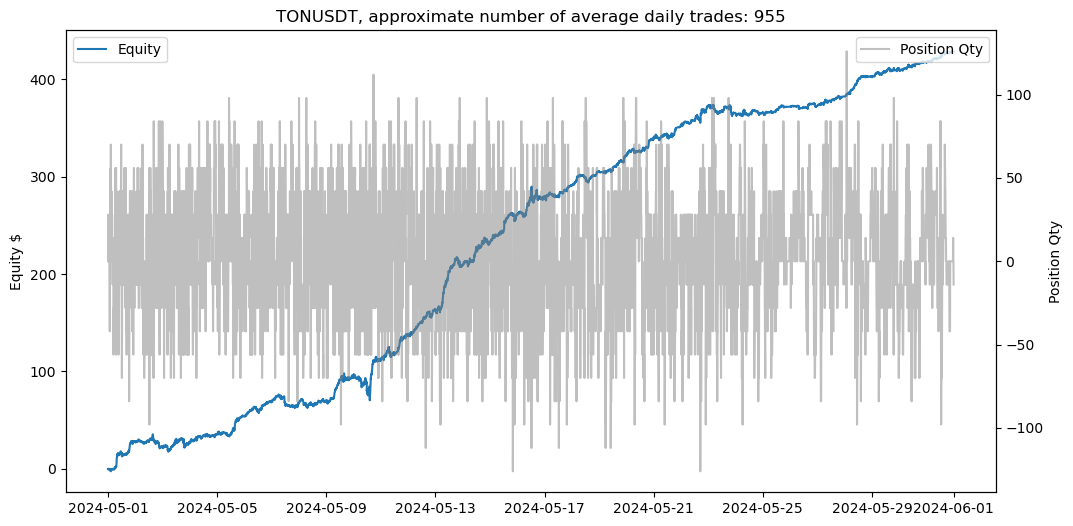

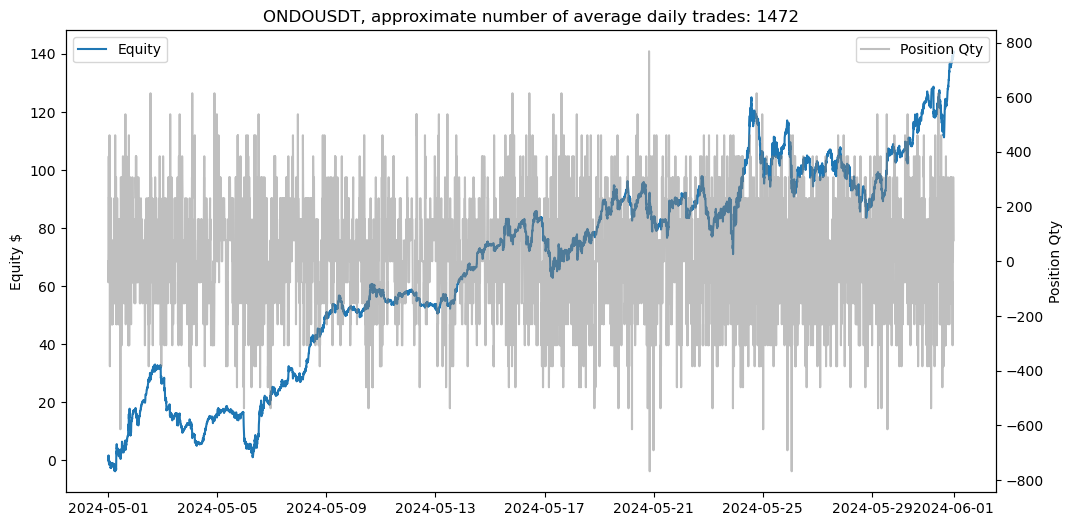

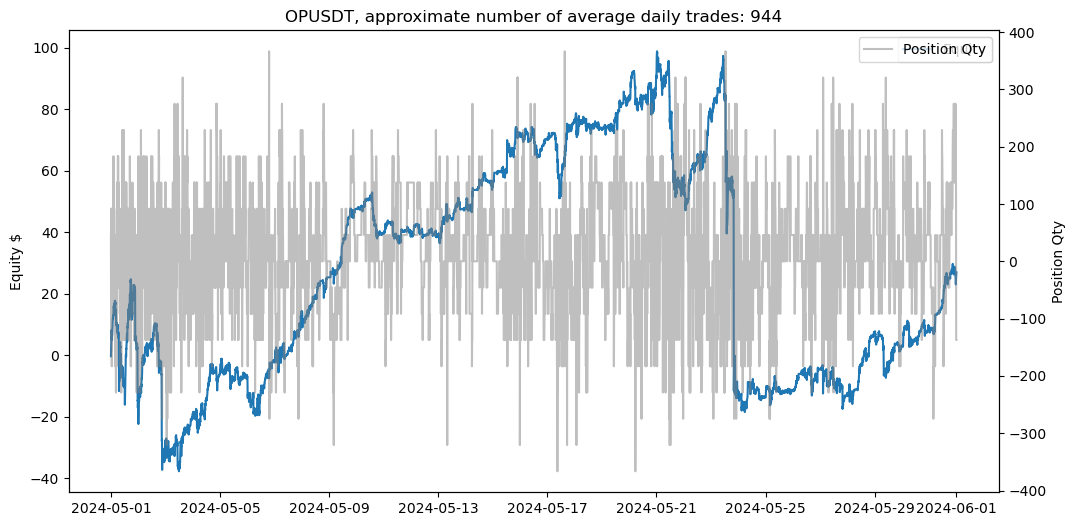

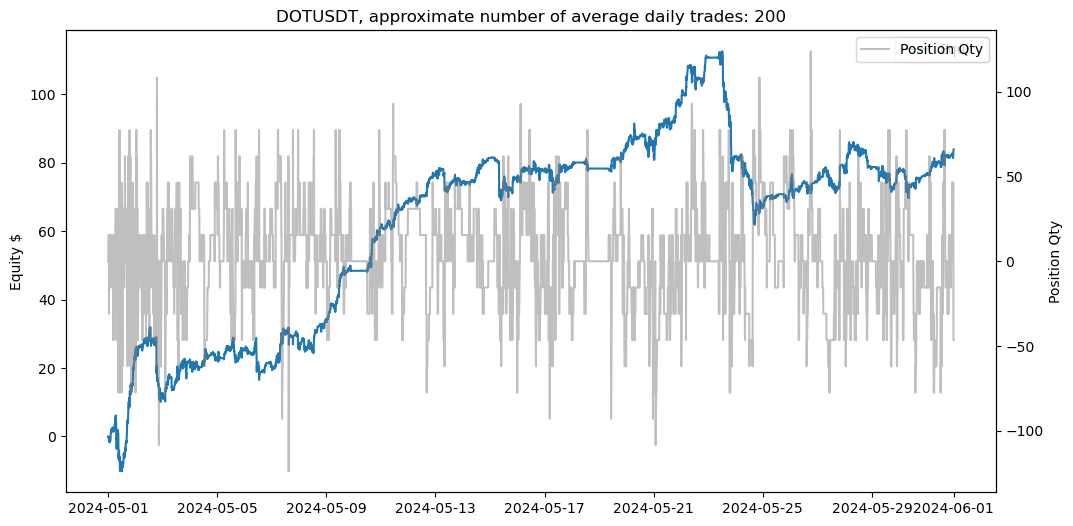

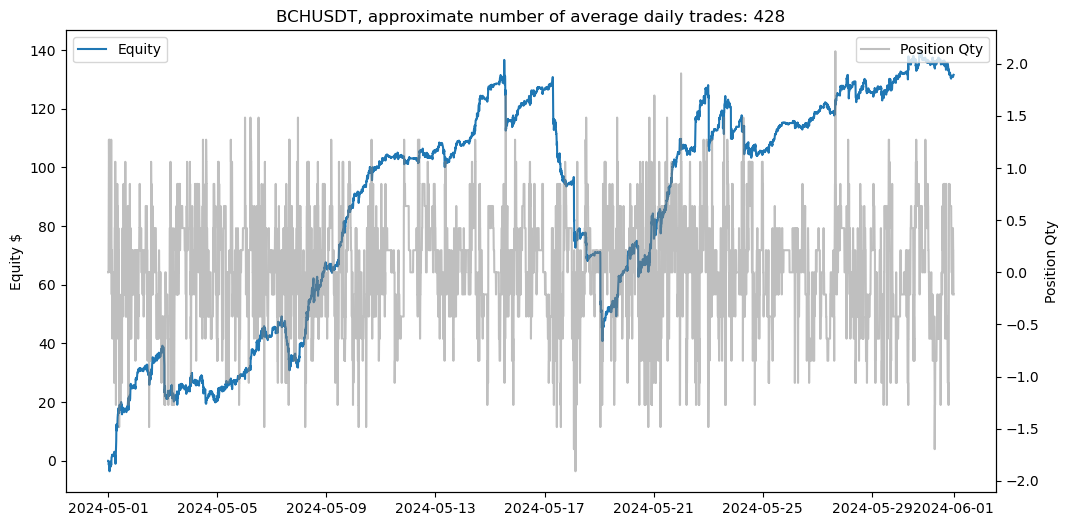

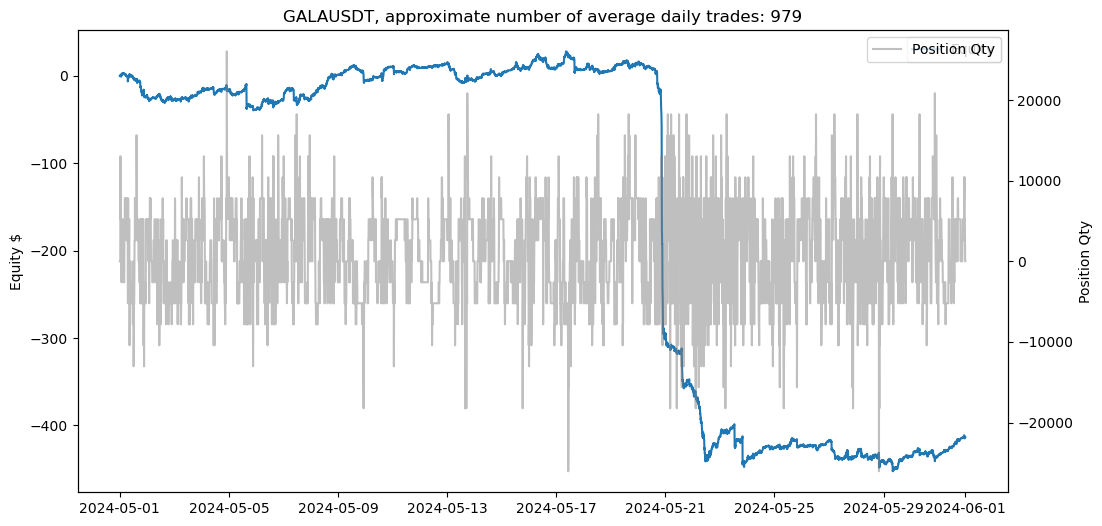

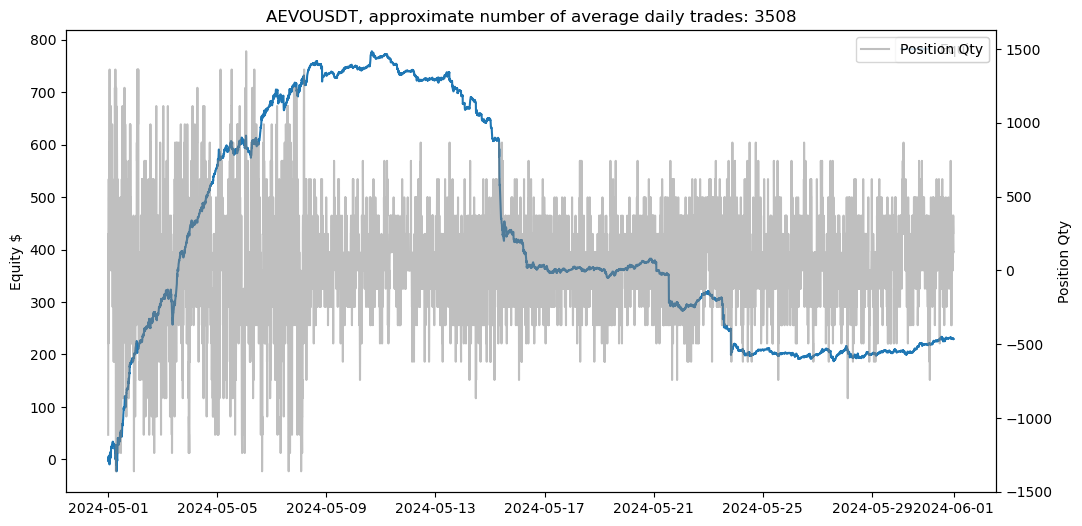

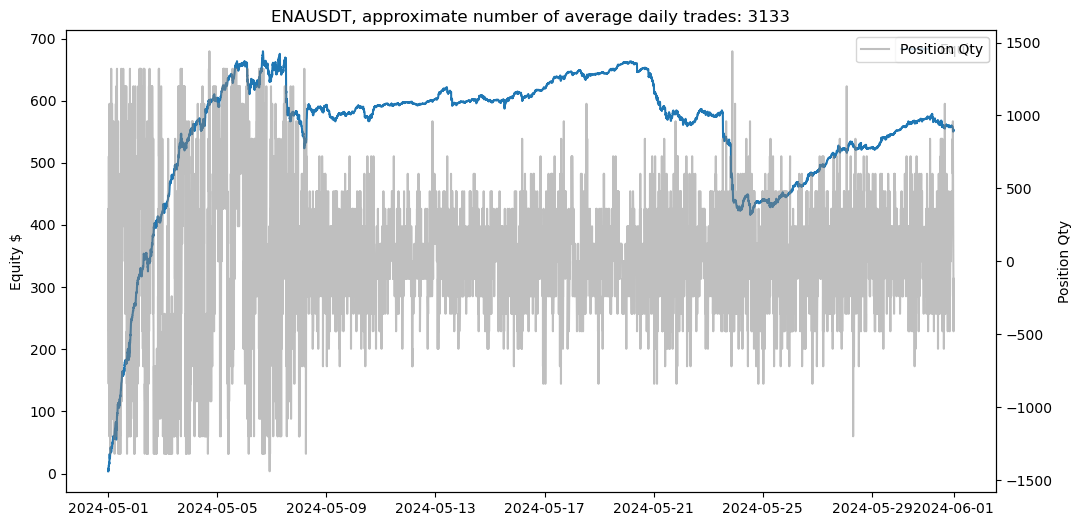

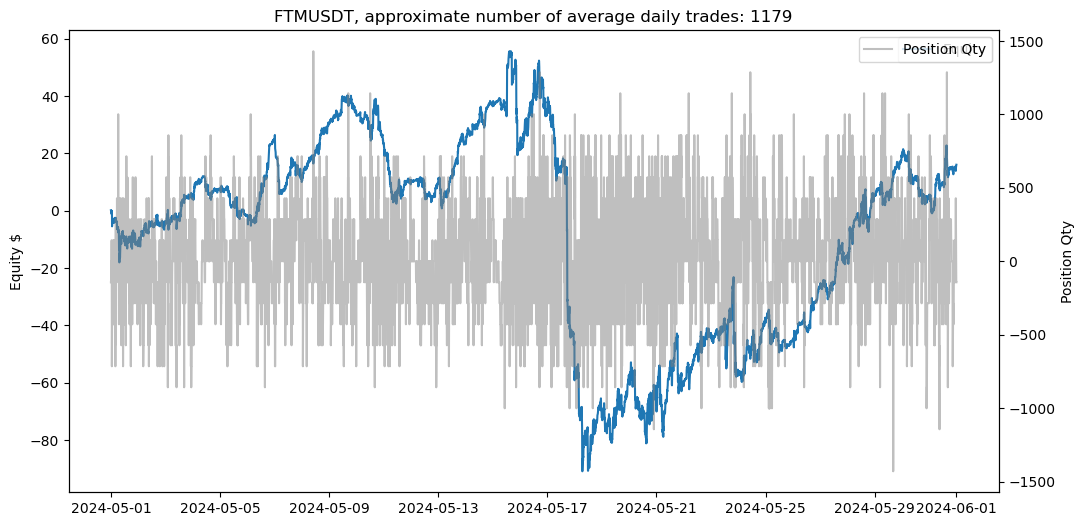

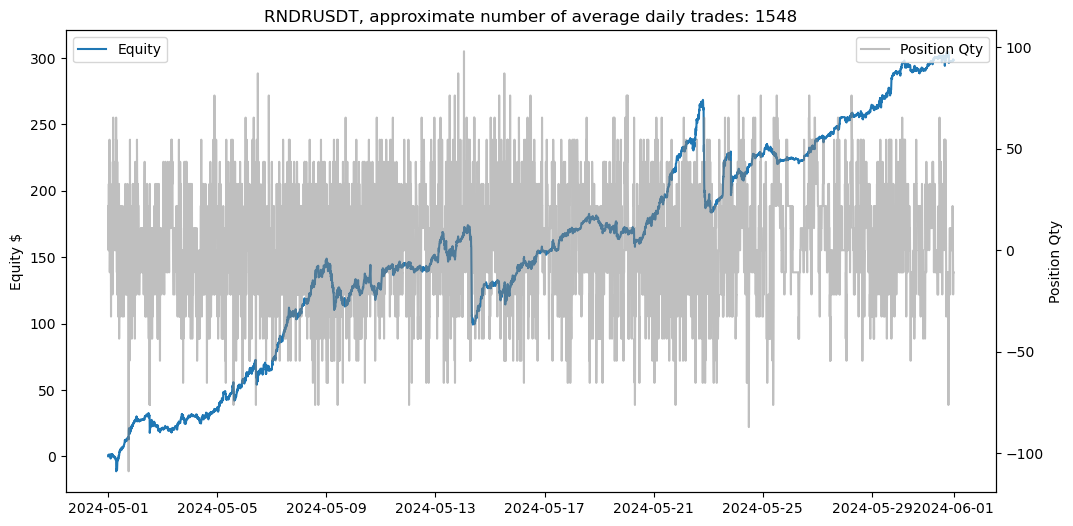

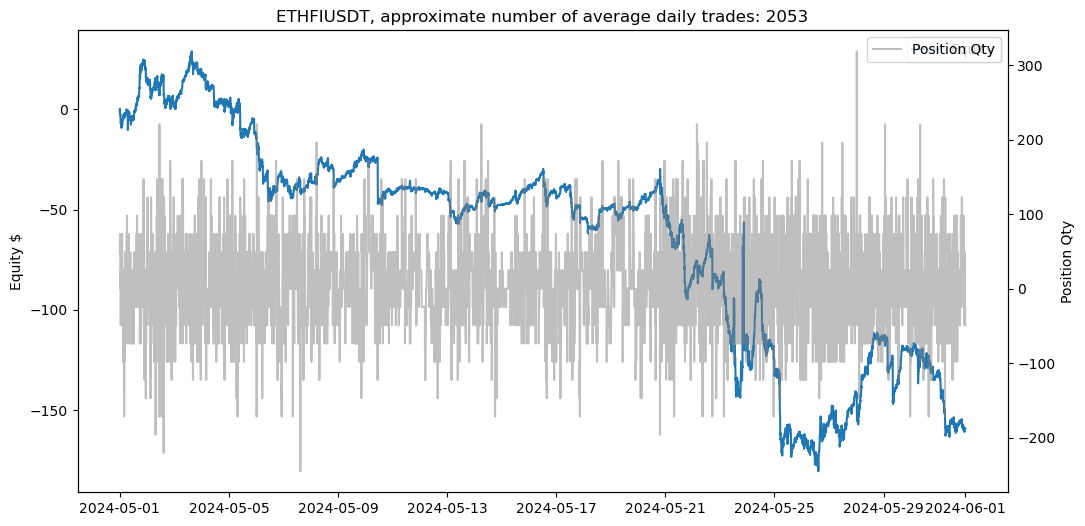

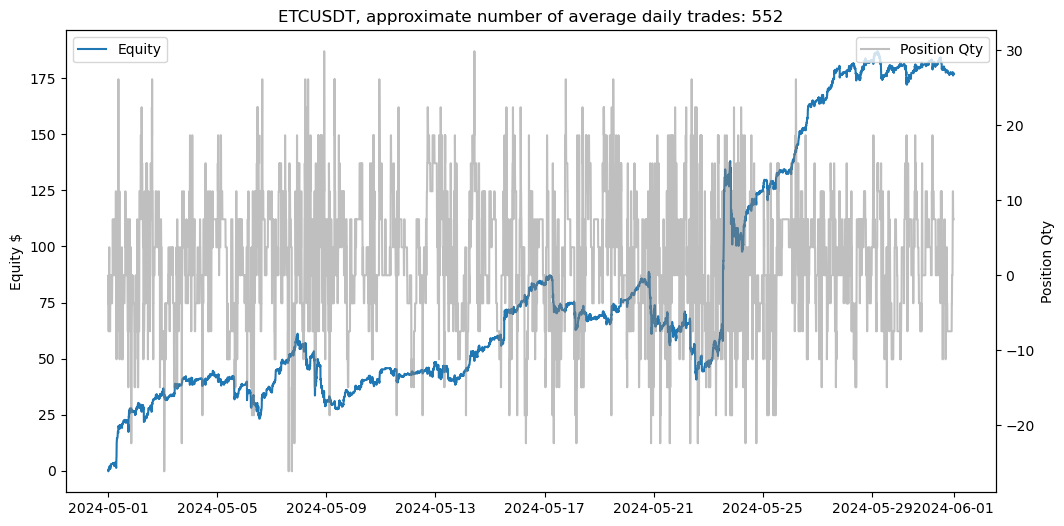

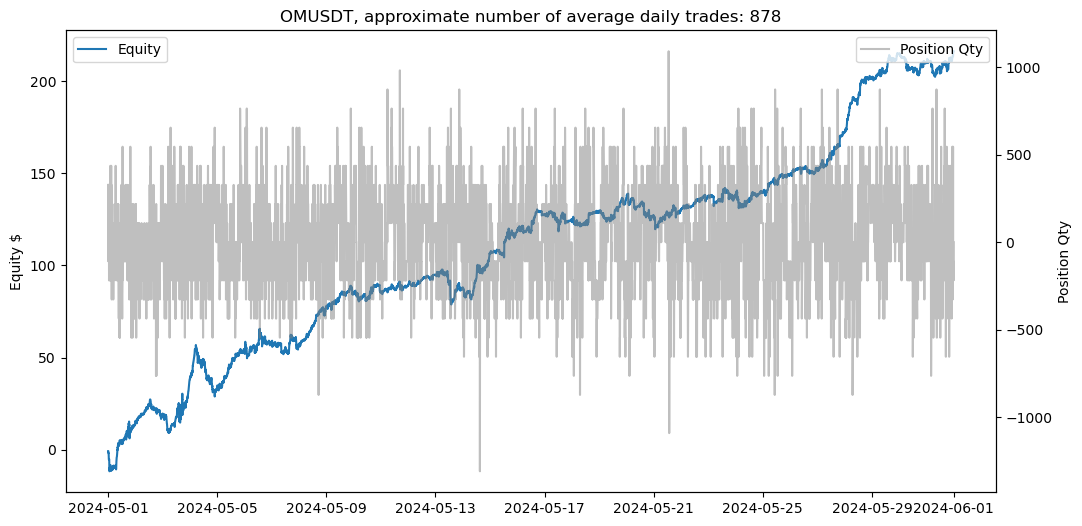

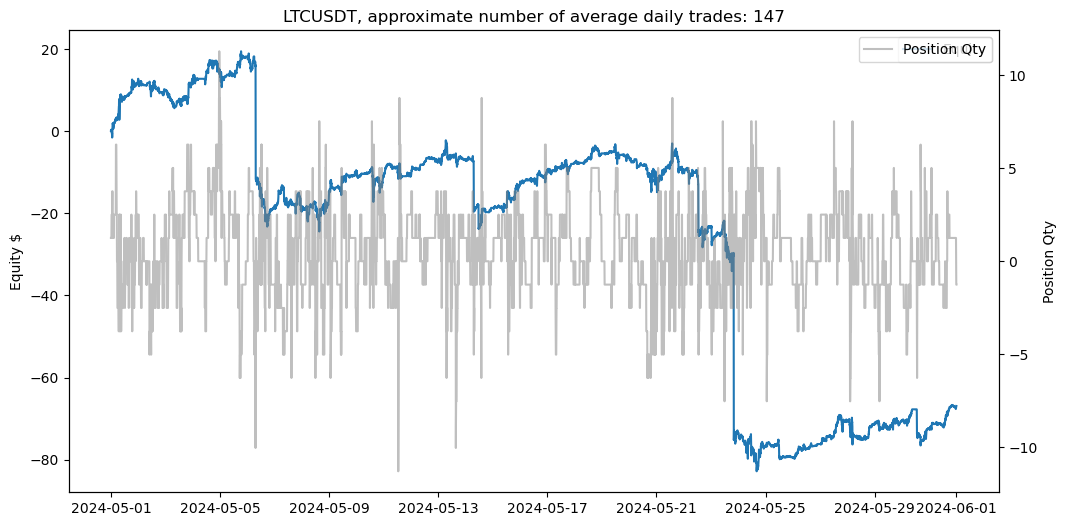

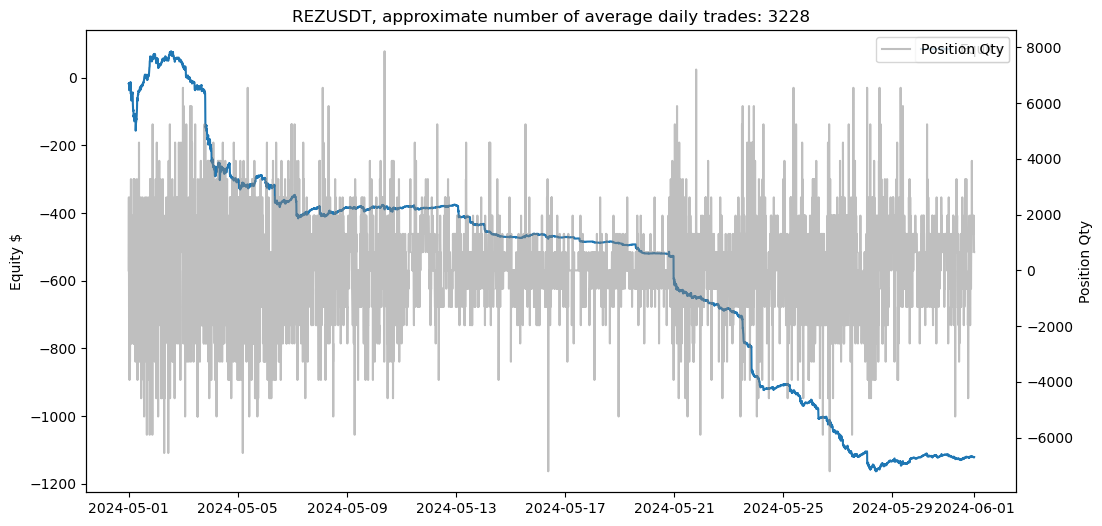

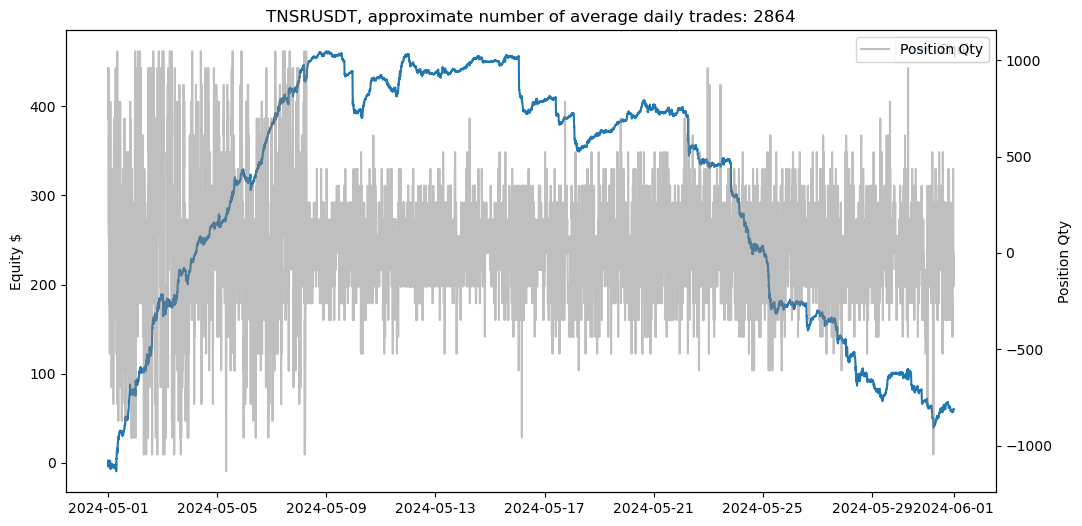

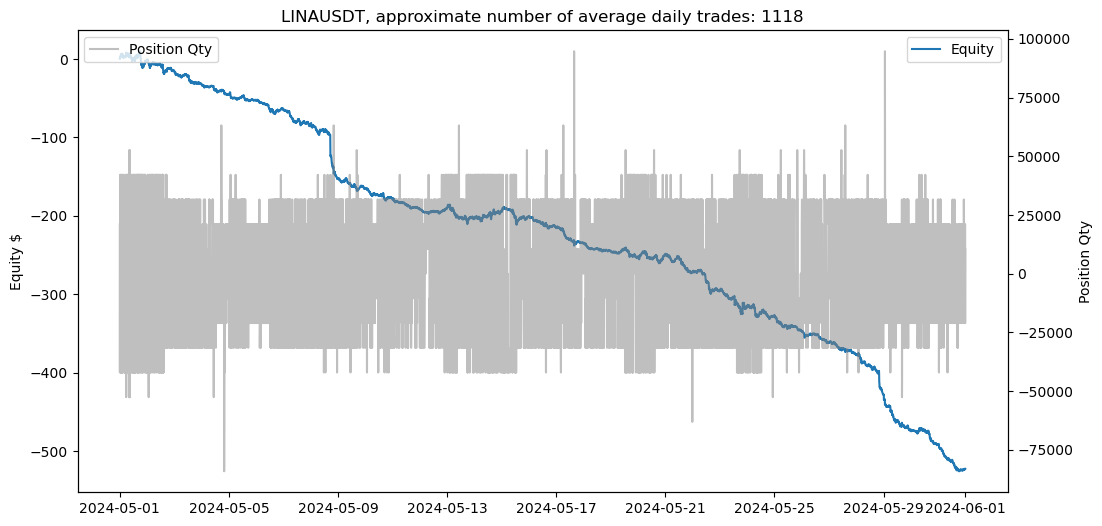

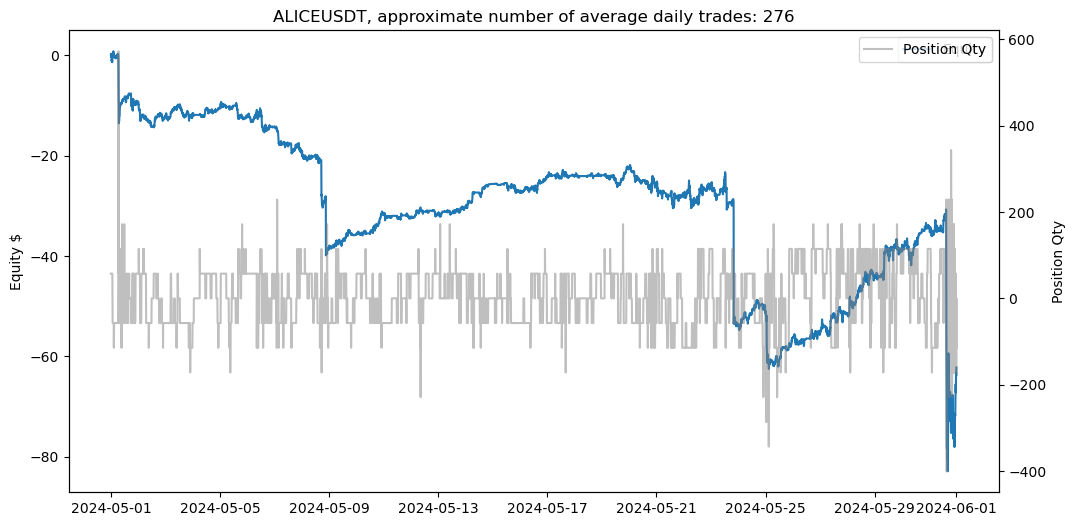

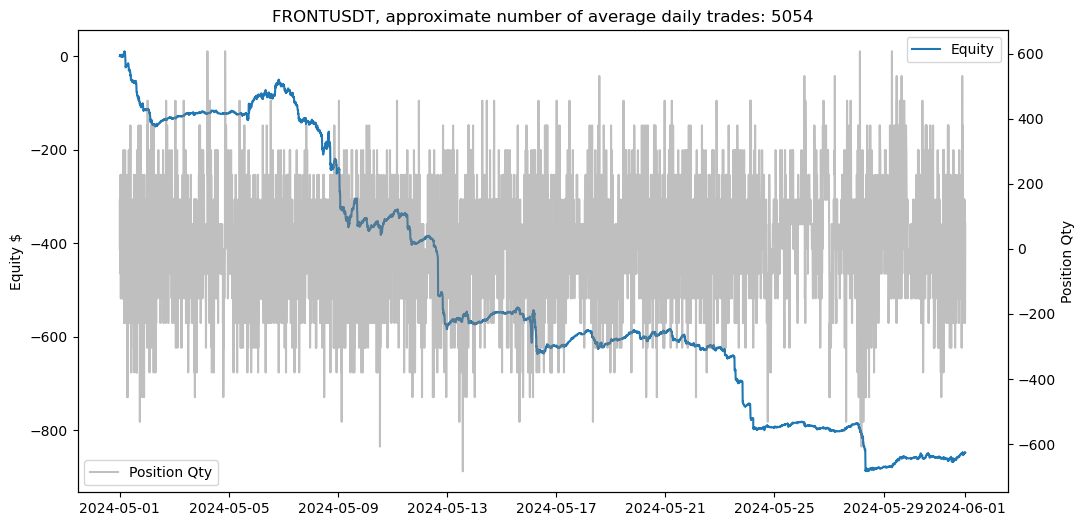

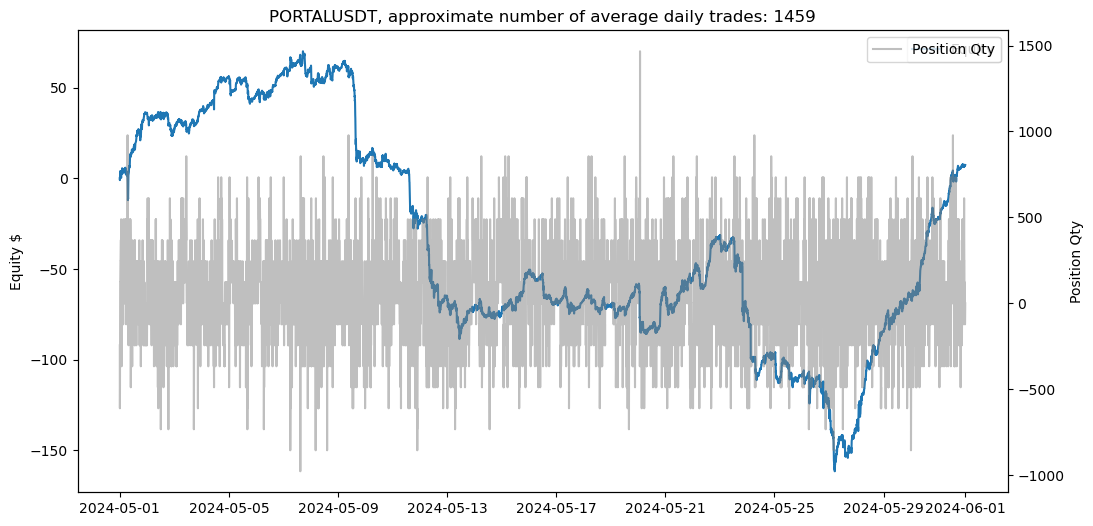

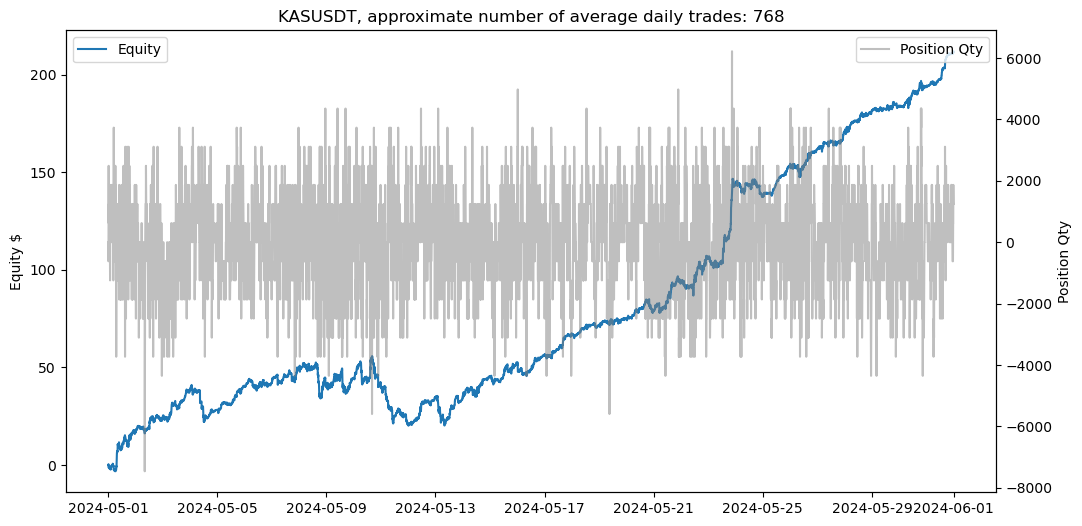

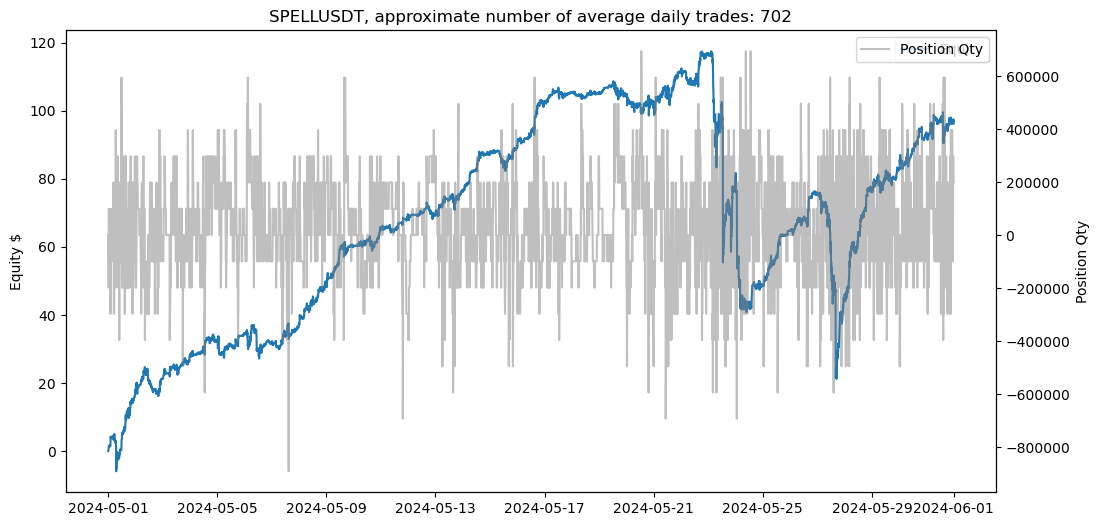

In [1]:
import pandas as pd
import re
import json
import os.path
from matplotlib import pyplot as plt

out_path = './out'
sel_pairs = []
sel_pairs_total_equity = None

with open('tickers.json', 'r') as f:
    tickers = json.load(f)

for i, symbol in enumerate(tickers.keys()):
    df = pd.read_csv(os.path.join(out_path, f'{symbol}0.csv'))
    df.index = pd.to_datetime(df['timestamp'])
    equity = df['balance'] + df['position'] * df['mid_price'] - df['fee']

    equity_5min = equity.resample('5min').last()

    notional_trade_value = df['position'].diff().abs().rolling('1d').sum().resample('1d').last() * df['mid_price'].resample('1d').last()
    # order_qty is set to approximately $100.
    approx_num_trades = notional_trade_value / 100
    avg_approx_num_trades = approx_num_trades.mean()
    
    fig = plt.figure(i, figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.set_title(f'{symbol}, approximate number of average daily trades: {avg_approx_num_trades:.0f}')
    ax.set_ylabel('Equity $')
    ax.plot(equity_5min)
    ax.legend(['Equity'])
    ax_pos = ax.twinx()
    ax_pos.set_ylabel('Position Qty')
    ax_pos.plot(df['position'].resample('5min').last(), 'gray', alpha=0.5)
    ax_pos.legend(['Position Qty'])

    # Selects only the positive ones, we will test this set in different months and the forward month as well.
    if equity.iloc[-1] > 0:
        sel_pairs.append(symbol)
        if sel_pairs_total_equity is None:
            sel_pairs_total_equity = equity_5min
        else:
            sel_pairs_total_equity += equity_5min

Please see [Making Multiple Markets - Introduction](https://hftbacktest.readthedocs.io/en/latest/tutorials/Making%20Multiple%20Markets%20-%20Introduction.html) to learn how combining multiple assets or strategies can create a better equity profile.

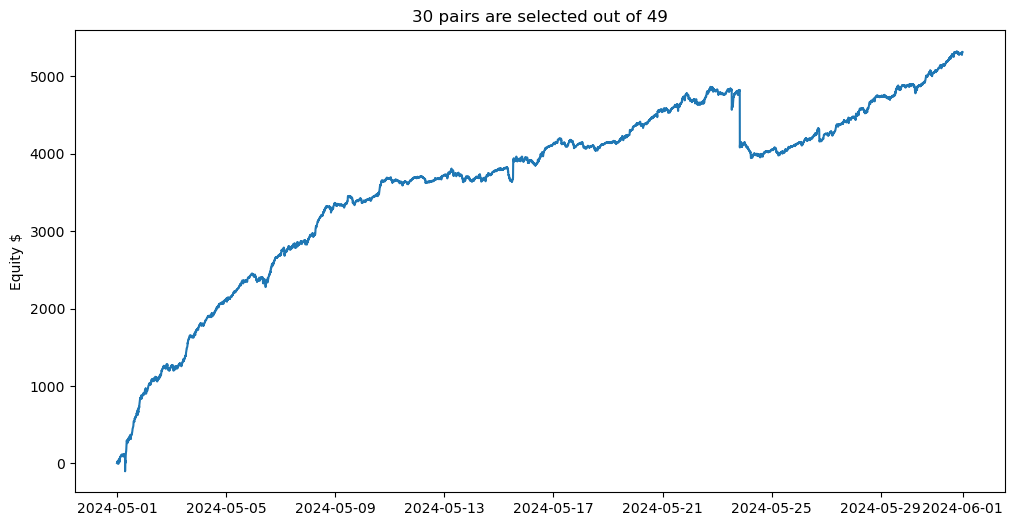

In [2]:
plt.figure(figsize=(12, 6))
plt.title(f'{len(sel_pairs)} pairs are selected out of {len(tickers)}')
plt.ylabel('Equity $')
plt.plot(sel_pairs_total_equity)

In [3]:
sel_pairs

['SOLUSDT',
 '1000PEPEUSDT',
 'ORDIUSDT',
 'BNBUSDT',
 'WIFUSDT',
 'DOGEUSDT',
 'JASMYUSDT',
 '1000FLOKIUSDT',
 'WLDUSDT',
 '1000SHIBUSDT',
 'OMGUSDT',
 'WAVESUSDT',
 'SOLUSDC',
 'AVAXUSDT',
 'NEARUSDT',
 'TONUSDT',
 'ONDOUSDT',
 'OPUSDT',
 'DOTUSDT',
 'BCHUSDT',
 'AEVOUSDT',
 'ENAUSDT',
 'FTMUSDT',
 'RNDRUSDT',
 'ETCUSDT',
 'OMUSDT',
 'TNSRUSDT',
 'PORTALUSDT',
 'KASUSDT',
 'SPELLUSDT']